In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import json
from PIL import Image
from collections import Counter
import pickle

In [40]:
base_path = '..'
generate_all_datset_annots = False
tile_categories = ['blood_vessel']
input_imgs_path = f'{base_path}/dataset1_files/all_dataset1_imgs' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_imgs'
output_annotations_path = f'{base_path}/dataset1_files/all_dataset1_annotations' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_annotations'
if not os.path.exists(output_annotations_path):
    os.mkdir(output_annotations_path)

In [41]:
def get_count_type(tiles_dict):
  ids_with_info = []
  for tile in tiles_dict:
    cur_dict = {'id': tile['id'], 'blood_vessel': 0, 'glomerulus': 0, 'unsure': 0}
    for annot in tile['annotations']:
      cur_dict[annot['type']] += 1
    ids_with_info.append(cur_dict)
  return ids_with_info

In [42]:
with open(f'{base_path}/polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)
    
    
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [43]:
tile_df = pd.read_csv(f'{base_path}/tile_meta.csv')
# Find the same stats as the above cell for annotated images
annotated_ids_with_info = get_count_type(tiles_dicts)
annotated_ids_with_info_df = pd.DataFrame.from_dict(annotated_ids_with_info)
tile_df_annotated = pd.merge(tile_df, annotated_ids_with_info_df, on='id', how='inner')
tile_df_annotated.head()

,id,source_wsi,dataset,i,j,blood_vessel,glomerulus,unsure
0,0006ff2aa7cd,2,2,16896,16420,8,1,0
1,00168d1b7522,2,2,14848,14884,1,1,0
2,0033bbc76b6b,1,1,10240,43008,3,0,1
3,003504460b3a,3,2,8192,11776,7,0,0
4,004daf1cbe75,3,2,6144,11264,10,1,0


In [44]:
tile_df_annotated.loc[(tile_df_annotated['glomerulus']>0) & (tile_df_annotated['dataset']==1)].shape

(34, 8)

In [45]:
dataset_1_tile_ids = sorted(tile_df_annotated.loc[tile_df_annotated['dataset']==1, 'id'].values)
# dataset_2_tile_ids = sorted(tile_df_annotated.loc[tile_df_annotated['dataset']==2, 'id'].values)

In [46]:
tgt_tile_dicts = [x for x in tiles_dicts if x['id'] in dataset_1_tile_ids] if not generate_all_datset_annots else tiles_dicts
print(len(tgt_tile_dicts))

422


In [47]:
tgt_tile_dicts[0]

{'id': '0033bbc76b6b',
 'annotations': [{'type': 'blood_vessel',
   'coordinates': [[[169, 228],
     [168, 228],
     [167, 228],
     [166, 228],
     [165, 228],
     [164, 228],
     [163, 228],
     [163, 227],
     [162, 227],
     [161, 227],
     [161, 226],
     [160, 226],
     [160, 225],
     [159, 225],
     [159, 224],
     [158, 224],
     [158, 223],
     [158, 222],
     [158, 221],
     [158, 220],
     [157, 220],
     [157, 219],
     [157, 218],
     [157, 217],
     [156, 217],
     [156, 216],
     [156, 215],
     [156, 214],
     [156, 213],
     [155, 213],
     [155, 212],
     [154, 212],
     [154, 211],
     [153, 211],
     [153, 210],
     [153, 209],
     [152, 209],
     [152, 208],
     [152, 207],
     [151, 207],
     [150, 207],
     [150, 206],
     [149, 206],
     [149, 205],
     [148, 205],
     [148, 204],
     [148, 203],
     [147, 203],
     [147, 202],
     [147, 201],
     [147, 200],
     [146, 200],
     [146, 199],
     [146, 198],
  

In [48]:
# def calculate_area(coordinates):
#     num_points = len(coordinates)
#     if num_points < 3:
#         return 0

#     area = 0
#     for i in range(num_points - 1):
#         x_i, y_i = coordinates[i]
#         x_iplus1, y_iplus1 = coordinates[i + 1]
#         area += (x_i * y_iplus1) - (x_iplus1 * y_i)

#     x_n, y_n = coordinates[-1]
#     x_0, y_0 = coordinates[0]
#     area += (x_n * y_0) - (x_0 * y_n)

#     area = abs(area / 2)
#     return area

In [49]:
def get_segmentation_coordinates(mask):
    mask = np.uint8(mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentation_coords = []
    for contour in contours:
        contour = np.squeeze(contour)
        coords = contour.flatten().tolist()
        segmentation_coords.append(coords)
    return segmentation_coords

In [50]:
glomerulus_img_ids = list(tile_df_annotated.loc[(tile_df_annotated['glomerulus']>0) & (tile_df_annotated['dataset']==1), 'id'].values)

In [51]:
test_glom_annots = dict()
for json_str in json_list:
    cur_json = json.loads(json_str)
    if cur_json['id'] in glomerulus_img_ids:
        glom_annots = []
        for annot in cur_json['annotations']:
            if annot['type'] == 'glomerulus':
                glom_mask = np.zeros((512,512), dtype='uint8')
                cv2.fillPoly(glom_mask, pts=[np.array(annot['coordinates'][0])], color=1)
                glom_annots.append(glom_mask)
        if len(glom_annots)>0:
            test_glom_annots[cur_json['id']] = np.stack(glom_annots)

def remove_glom_regions(mask, glom_masks):
    mask = np.expand_dims(mask, axis=0)
    mask_is_one = (mask == 1)
    glom_is_zero = (glom_masks == 0)
    mask_glom_intersection_masks = np.logical_and(mask_is_one, glom_is_zero)
    return np.all(mask_glom_intersection_masks, axis=0).astype('uint8')

In [52]:
for tgt_tile_dict in tgt_tile_dicts:
  cur_tile_coco_annots = []
  img_id = tgt_tile_dict['id']
  annotations = [annot for annot in tgt_tile_dict['annotations'] if annot['type'] in tile_categories]
  for annot in annotations:
    coords = annot['coordinates'][0]
    if img_id in test_glom_annots and annot['type']=='blood_vessel':
        mask = np.zeros((512,512), dtype='uint8')
        cv2.fillPoly(mask, pts=[np.array(coords)], color=1)
#         blood_vessel_wo_glom = remove_glom_regions(mask, test_glom_annots[img_id])
        glom_masks = test_glom_annots[img_id]
#         print(glom_masks.shape)
        for i in range(glom_masks.shape[0]):
            mask *= 1-glom_masks[i,:,:]
        segmentations = get_segmentation_coordinates(mask)
    else:
        segmentations = [[pt for pair in coords for pt in pair]]
    min_x = min(coords, key=lambda x: x[0])[0]
    max_x = max(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_y = max(coords, key=lambda x: x[1])[1]
    segmentation_bbox = [min_x, min_y, max_x-min_x, max_y-min_y]
    category_id = tile_categories.index(annot['type'])
    cur_tile_coco_annots.append({
      'segmentation': segmentations,
      'bbox': segmentation_bbox,
      'category_id': category_id
    })
  with open(f'{output_annotations_path}/{img_id}.pkl', 'wb') as f:
    pickle.dump(cur_tile_coco_annots, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
img_annot_files = os.listdir(output_annotations_path)
img_annot_files[67:72]

In [ ]:
import random
img_annot_file = random.choice(img_annot_files)

In [ ]:
img_annot_file

In [53]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:

tgt_annot_files = ['5ea525251225.pkl']
# for i in range(10):
#   img_annot_file = random.choice(img_annot_files)
for img_annot_file in tgt_annot_files:
  img_id = img_annot_file.split('.')[0]
  with open(f'{output_annotations_path}/{img_annot_file}', 'rb') as f:
    tgt_annots = pickle.load(f)
  # print(tgt_annots)
  tgt_annots = [annot for annot in tgt_annots if annot['category_id']==0]
  base_image = cv2.imread(f'{input_imgs_path}/{img_id}.png')
  base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
  annotated_image_orig = copy.deepcopy(base_image)
  annotated_image_coco = copy.deepcopy(base_image)
  imgs_dict = dict()
  imgs_dict['base_image'] = base_image
  for tgt_annot in tgt_annots:
    coords = [[x, y] for x, y in zip(tgt_annot['segmentation'][0][::2], tgt_annot['segmentation'][0][1::2])]
    min_x, min_y, width, height = tgt_annot['bbox']
    cv2.fillPoly(annotated_image_coco, pts=[np.array(coords)], color=(0,255,0))
    top_left = (int(tgt_annot['bbox'][0]), int(tgt_annot['bbox'][1]))
    min_x = min(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_x = max(coords, key=lambda x: x[0])[0]
    max_y = max(coords, key=lambda x: x[1])[1]
    bottom_right = (int(tgt_annot['bbox'][0]+tgt_annot['bbox'][2]), int(tgt_annot['bbox'][1]+tgt_annot['bbox'][3]))
    annotated_image_coco = cv2.rectangle(annotated_image_coco, top_left, bottom_right, (255,0,0), 2)

  tgt_orig_annots = [annot for annot in [x for x in tgt_tile_dicts if x['id']==img_id][0]['annotations'] if annot['type']=='blood_vessel']
  for tgt_orig_annot in tgt_orig_annots:
    coords = tgt_orig_annot['coordinates']
    cv2.fillPoly(annotated_image_orig, pts=[np.array(coords)], color=(0,255,0))
  imgs_dict['annotated_image_orig'] = annotated_image_orig
  imgs_dict['annotated_image_coco'] = annotated_image_coco
  visualize(**imgs_dict)

In [ ]:
glomerulus_img_ids

In [ ]:
test_glom_annots['0754412b2917'].shape

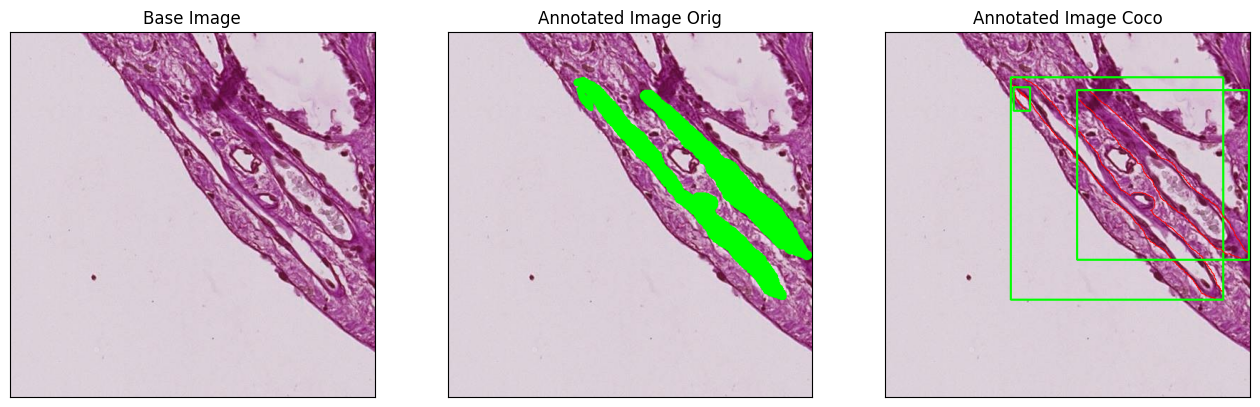

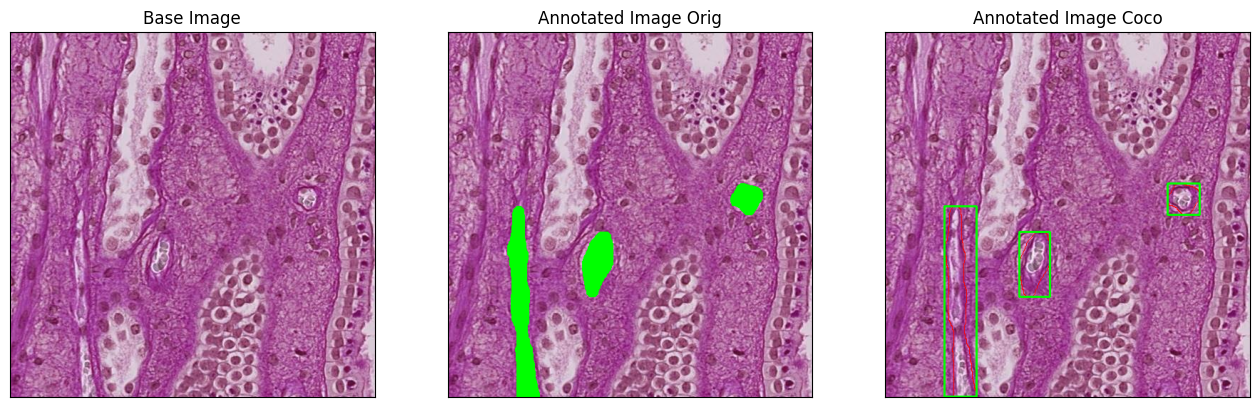

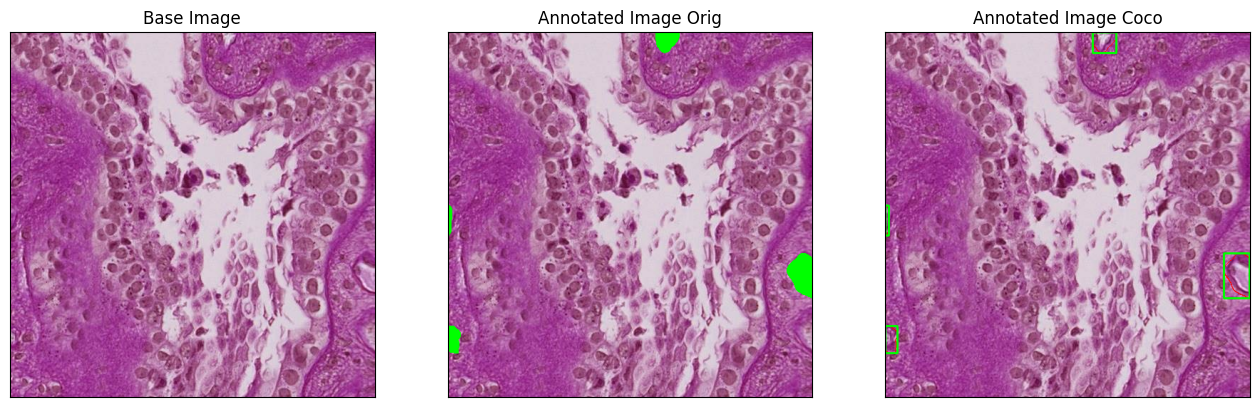

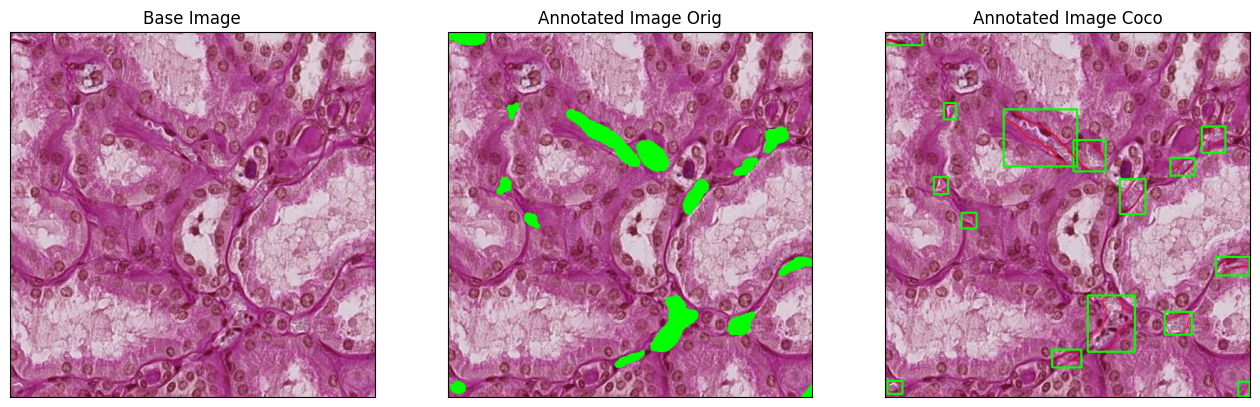

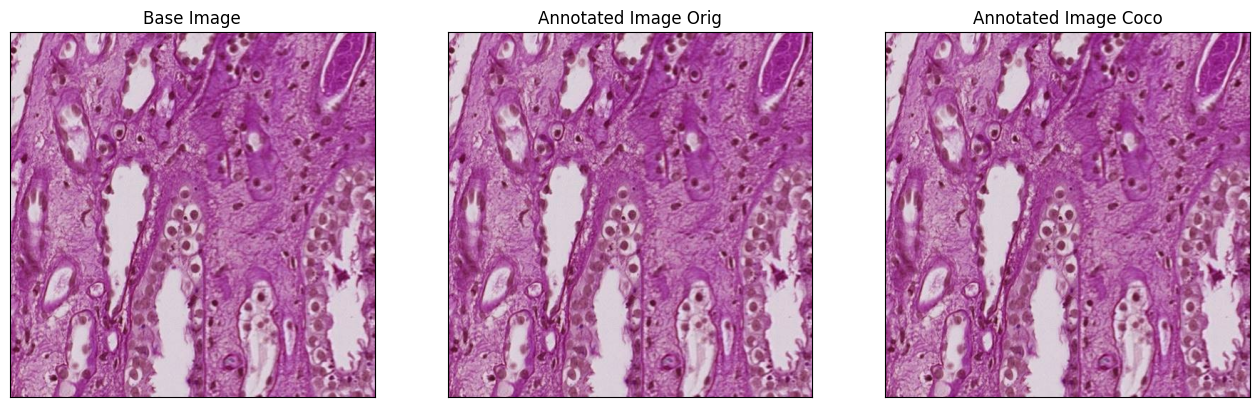

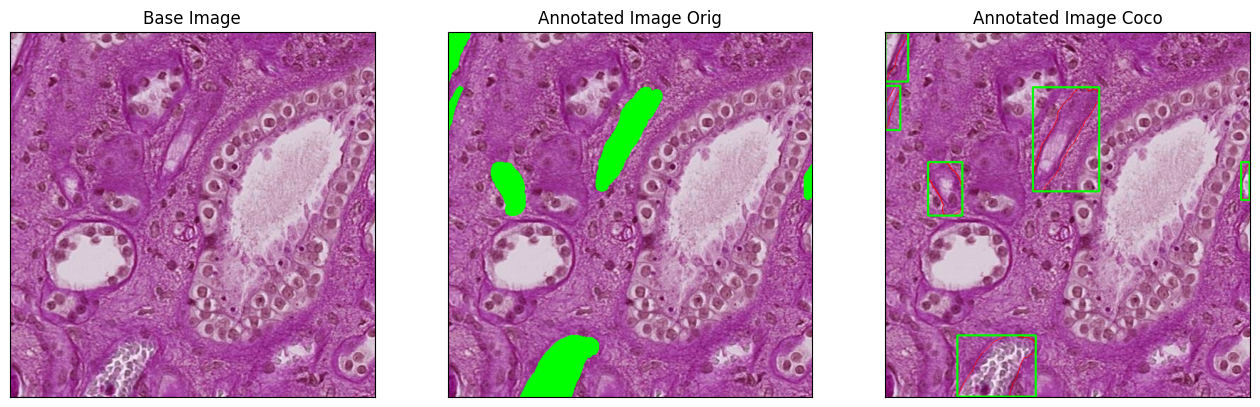

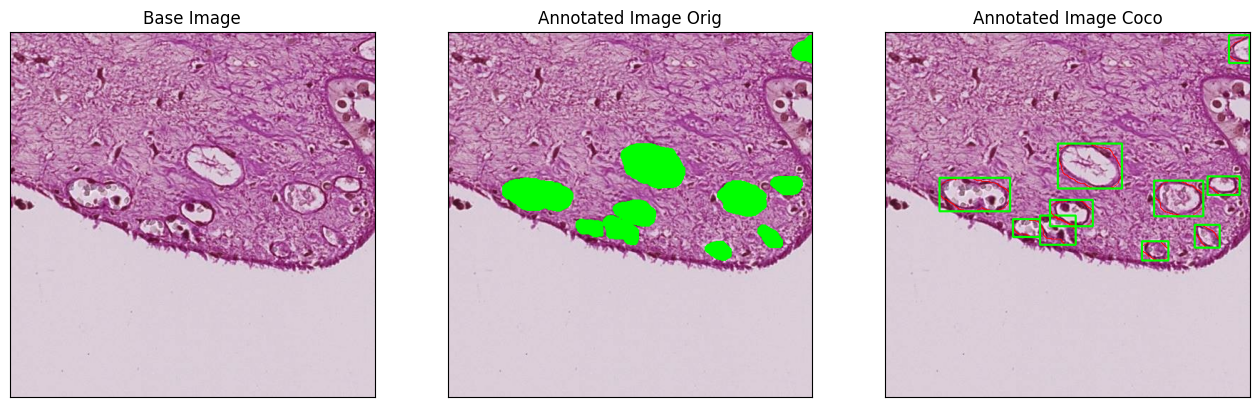

In [62]:
import copy
# for img_id in glomerulus_img_ids[:5]:
for img_id in ['e6d9bd78b840', 'a3ebac2db19d', '3b83d7668181', '103906a73e6d', 'f45a29109ff5', '65a235166914', 'ce27b0613895']:
  with open(f'{output_annotations_path}/{img_id}.pkl', 'rb') as f:
    tgt_annots = pickle.load(f)
  base_image = cv2.imread(f'{input_imgs_path}/{img_id}.png')
  base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
  annotated_image_orig = copy.deepcopy(base_image)
  annotated_image_coco = copy.deepcopy(base_image)
  imgs_dict = dict()
  imgs_dict['base_image'] = base_image
  for tgt_annot in tgt_annots:
    coords = [[x, y] for x, y in zip(tgt_annot['segmentation'][0][::2], tgt_annot['segmentation'][0][1::2])]
    min_x, min_y, width, height = tgt_annot['bbox']
    top_left = (int(tgt_annot['bbox'][0]), int(tgt_annot['bbox'][1]))
    min_x = min(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_x = max(coords, key=lambda x: x[0])[0]
    max_y = max(coords, key=lambda x: x[1])[1]
    bottom_right = (int(tgt_annot['bbox'][0]+tgt_annot['bbox'][2]), int(tgt_annot['bbox'][1]+tgt_annot['bbox'][3]))
    if tgt_annot['category_id'] == 0:    
        cv2.polylines(annotated_image_coco, [np.array(coords)], isClosed=True, color=(255, 0, 0), thickness=1)
        annotated_image_coco = cv2.rectangle(annotated_image_coco, top_left, bottom_right, (0,255,0), 2)
    elif tgt_annot['category_id'] == 1:
#         cv2.fillPoly(annotated_image_coco, pts=[np.array(coords)], color=(0,255,0))
        cv2.polylines(annotated_image_coco, [np.array(coords)], isClosed=True, color=(255, 0, 0), thickness=1)
        annotated_image_coco = cv2.rectangle(annotated_image_coco, top_left, bottom_right, (255,0,0), 2)
    elif tgt_annot['category_id'] == 2:
        print('ERROR FOUND UNSURE!!!!!')
    tgt_orig_annots = [annot for annot in [x for x in tgt_tile_dicts if x['id']==img_id][0]['annotations'] if annot['type']!='unsure']
    for tgt_orig_annot in tgt_orig_annots:
        coords = tgt_orig_annot['coordinates']
        cv2.fillPoly(annotated_image_orig, pts=[np.array(coords)], color=(0,255,0))
  imgs_dict['annotated_image_orig'] = annotated_image_orig
  imgs_dict['annotated_image_coco'] = annotated_image_coco
  visualize(**imgs_dict)